In [1]:
import pystan

Book website: https://www.mbr-pwrc.usgs.gov/pubanalysis/roylebook/chapters.htm

#### 3.3.2. Logistic regression in Winbugs

In [2]:
import pandas as pd
swiss = pd.read_csv('../data/book_data/wtmatrix.csv')
swiss.head()

,y.1,y.2,y.3,c.1,c.2,c.3,elev,forest,dur.1,dur.2,dur.3,day.1,day.2,day.3,length
0,0,0.0,0.0,0,0.0,0.0,420,3,240,240.0,240.0,29,58,73.0,6.2
1,0,0.0,0.0,0,0.0,0.0,450,21,160,155.0,140.0,13,39,62.0,5.1
2,0,0.0,0.0,0,0.0,0.0,1050,32,120,105.0,85.0,30,47,74.0,4.3
3,0,0.0,0.0,0,0.0,0.0,1110,35,180,170.0,145.0,23,44,71.0,5.4
4,0,0.0,0.0,0,0.0,0.0,510,2,210,225.0,235.0,28,56,73.0,3.6


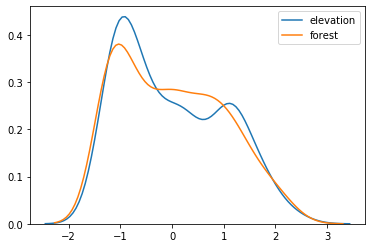

In [3]:
from sklearn.preprocessing import scale

elev = scale(swiss["elev"])
forest = scale(swiss["forest"])

import seaborn as sns
sns.kdeplot(elev, label='elevation')
sns.kdeplot(forest, label='forest')

import matplotlib.pyplot as plt
plt.legend();

pamat = swiss[['y.1', 'y.2', 'y.3']]
pamat.head(30)
pamat.max() # check: binarized counts

z = pamat['y.1'].values
M = len(z)

In [4]:
code = """
data {
    int<lower=0> M; // total number of observations (quadrats)
    int<lower=0, upper=1> z[M]; // observations (binary)
    vector[M] elev; // elevation covariate
    vector[M] forest; // forestation covariate
}

transformed data {
  // precalculate the squares
  vector[M] elev2;
  elev2 <- square(elev);
  
  //for (i in 1:M)
  //  elev2[i] = square(elev[i]);
}

parameters {
    real b0;
    real b1;
    real b2;
    real b3;
}

transformed parameters {}

model {
    // priors: WinBugs priors didn't work, so I followed the recommendations
    // for a "Weakly informative prior" here:
    // https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
    b0 ~ normal(0, 10);
    b1 ~ normal(0, 10);
    b2 ~ normal(0, 10);
    b3 ~ normal(0, 10);
    
    // actual model
    for (i in 1:M) {
        z[i] ~ bernoulli_logit(b0 + b1 * elev[i] + b2*elev2[i] + b3*forest[i]);
    }
}

generated quantities {}
"""

swiss_data = {'M': M,
              'z': z,
              'forest': forest,
              'elev': elev
             }

sm = pystan.StanModel(model_code=code)
fit = sm.sampling(data=swiss_data, iter=10000,
                  chains=4, warmup=1000, thin=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_92bb4efe77b5b765cedc4eb3d04dffe4 NOW.


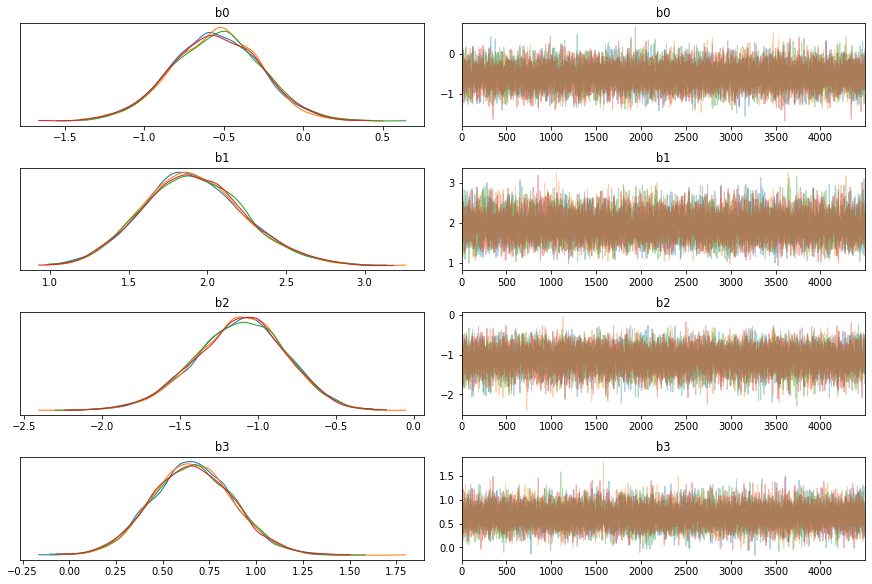

In [5]:
import arviz as az
inference_data = az.from_pystan(fit)
az.plot_trace(inference_data);

This result is acceptably close to the results reported on p. 99:

In [6]:
fit

Inference for Stan model: anon_model_92bb4efe77b5b765cedc4eb3d04dffe4.
4 chains, each with iter=10000; warmup=1000; thin=2; 
post-warmup draws per chain=4500, total post-warmup draws=18000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b0    -0.55  2.3e-3   0.28  -1.11  -0.74  -0.55  -0.36-5.7e-3  14141    1.0
b1     1.92  2.7e-3   0.33   1.32   1.69    1.9   2.13    2.6  14325    1.0
b2    -1.11  2.5e-3   0.29  -1.71  -1.31   -1.1  -0.92  -0.57  13833    1.0
b3     0.66  1.8e-3   0.22   0.24   0.51   0.66   0.81    1.1  15483    1.0
lp__ -102.9    0.01   1.41 -106.4 -103.6 -102.6 -101.9 -101.1  12366    1.0

Samples were drawn using NUTS at Mon Dec 14 23:14:06 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

How they get to $A_{occ}$ is unclear to me...

### 3.3 MODELS OF OCCUPANCY ALLOWING FOR IMPERFECT OBSERVATION